<a href="https://colab.research.google.com/github/Sno3mahn/Spam-Filter/blob/main/Spam_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importing required libraries and modules

In [1]:
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from imblearn.combine import SMOTETomek
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/spam.csv', encoding='latin-1')
df.shape

(5572, 5)

###Remove duplicate records

In [4]:
df=df.drop_duplicates()
df.reset_index(drop=True, inplace=True)
df.shape

(5169, 5)

In [5]:
df.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


###Drop attributes where attributes are NaN

In [6]:
df=df.drop(labels=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)

###Check for any remaining empty records

In [7]:
df.isna().sum()

v1    0
v2    0
dtype: int64

###Rename columns with appropriate labels

In [8]:
df=df.rename({'v1':'Target', 'v2':'Text'}, axis='columns')

###Encode target into numerical values

In [9]:
le=LabelEncoder()
df['Target']=le.fit_transform(df['Target'])

####The clean-up function involves tokenizing the corpus, removing numbers and punctuations

In [10]:
def cleanup(text):
  text= nltk.tokenize.word_tokenize(text)
  text=[word.lower() for word in text if word.isalpha()]
  return text

In [11]:
df['Text']=df['Text'].apply(cleanup)

In [12]:
df.head(10)

,Target,Text
0,0,"[go, until, jurong, point, available, only, in..."
1,0,"[ok, lar, joking, wif, u, oni]"
2,1,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,0,"[u, dun, say, so, early, hor, u, c, already, t..."
4,0,"[nah, i, do, think, he, goes, to, usf, he, liv..."
5,1,"[freemsg, hey, there, darling, it, been, week,..."
6,0,"[even, my, brother, is, not, like, to, speak, ..."
7,0,"[as, per, your, request, melle, oru, minnaminu..."
8,1,"[winner, as, a, valued, network, customer, you..."
9,1,"[had, your, mobile, months, or, more, u, r, en..."


###Remove outliers to reduce no of overall features.
To achieve this, we create another column containing the no of tokens in each corpus, and then plot it against targets to find a sweet spot for outlier detection.

In [13]:
df['Word_freq']=df['Text'].apply(lambda row: len(row))

####We arbitrarily set 100 as the limit for corpus as, any further the model will not be able to generalize and we will also have a high number of features

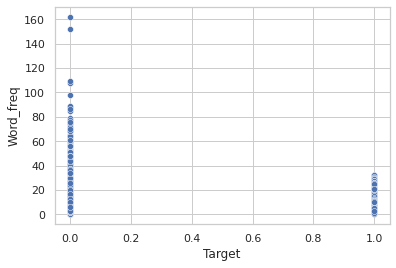

In [14]:
sns.set(style='whitegrid')
sns.scatterplot(x=df['Target'],y=df['Word_freq'], data='df')

In [15]:
df=df[(df['Word_freq']<100)]
df.reset_index(drop=True, inplace=True)
df.shape

(5165, 3)

###Remove stop words as they don't contribute much to the models prediction ability

In [16]:
def stopwordCleanup(text):
  stop_words=set(stopwords.words('english'))
  non_stop=[ i for i in text if i not in stop_words ]
  return non_stop

In [17]:
df['Text']=df['Text'].apply(stopwordCleanup)

###Lemmatize tokens into their root form so that the model treats those words as one.
Eg: is, are, be: be

In [18]:
lemma=WordNetLemmatizer()
def lemmatization(text):
  lemmas=[ lemma.lemmatize(i) for i in text ]
  return lemmas

In [19]:
df['Text']=df['Text'].apply(lemmatization)

###Join the tokens back into a corpus

In [21]:
text=[]
for i in df['Text']:
  text.append(' '.join(i))

###Vectorize tokens.
Since, models can only handle numeric values, we shall convert them into a vector of real numbers derived by TF-IDF approach.
TermFrequncy-InverseDocumentFrequency: is a statistical method of figuring out the relevance of a word within a document pertaining to its frequency

In [22]:
tf_idf=TfidfVectorizer()
X=tf_idf.fit_transform(text).toarray()
y=df['Target']

In [23]:
X.shape, y.shape

((5165, 6524), (5165,))

Note that no. of spam features are only a small fraction of the non-spam features. So, we have to handle this imbalance.

In [24]:
y.value_counts()

0    4512
1     653
Name: Target, dtype: int64

###We use SMOTE (Synthetic Minority Oversampling Technique) to upsample our minority feature - 'spam'

In [ ]:
sm=SMOTETomek(random_state=42)
X_res, y_res=sm.fit_resample(X,y)
X_res.shape, y_res.shape

((9024, 6524), (9024,))

####Perform train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

###We try out these Alogrithms to find out which best suits our use-case

1.   Support Vector Machines
2.   Logistic Regression
3.   K-Nearest Neighbors
4.   Random Forest Classifier
5.   Gaussian Naive Bayes
6.   Multinomila Naive Bayes

In [ ]:
sv=SVC()
sv.fit(X_train,y_train)
y_pred_svm = sv.predict(X_test)

In [ ]:
print("SVM")
print("Confusion Matrix: ",confusion_matrix(y_pred_svm,y_test))
print("Accuracy:",accuracy_score(y_pred_svm, y_test)*100)
print("Classification Report:\n", classification_report(y_pred_svm, y_test))

SVM
Confusion Matrix:  [[909   3]
 [  7 886]]
Accuracy: 99.44598337950139
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       912
           1       1.00      0.99      0.99       893

    accuracy                           0.99      1805
   macro avg       0.99      0.99      0.99      1805
weighted avg       0.99      0.99      0.99      1805



In [ ]:
reg= LogisticRegression()
reg.fit(X_train,y_train)
y_pred_reg = reg.predict(X_test)

In [ ]:
print("Logistic Regression")
print("Confusion Matrix: ",confusion_matrix(y_pred_reg,y_test))
print("Accuracy:",accuracy_score(y_pred_reg, y_test)*100)
print("Classification Report:\n", classification_report(y_pred_reg, y_test))

Logistic Regression
Confusion Matrix:  [[894  58]
 [ 22 831]]
Accuracy: 95.56786703601108
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       952
           1       0.93      0.97      0.95       853

    accuracy                           0.96      1805
   macro avg       0.96      0.96      0.96      1805
weighted avg       0.96      0.96      0.96      1805



In [ ]:
knn=KNeighborsClassifier(n_neighbors=29)
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)

In [ ]:
print("KNN")
print("Confusion Matrix: ",confusion_matrix(y_pred_knn,y_test))
print("Accuracy:",accuracy_score(y_pred_knn, y_test)*100)
print("Classification Report:\n", classification_report(y_pred_knn, y_test))

KNN
Confusion Matrix:  [[849  74]
 [ 67 815]]
Accuracy: 92.18836565096953
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92       923
           1       0.92      0.92      0.92       882

    accuracy                           0.92      1805
   macro avg       0.92      0.92      0.92      1805
weighted avg       0.92      0.92      0.92      1805



In [ ]:
rfor=RandomForestClassifier(n_estimators=100)
rfor.fit(X_train,y_train)
y_pred_rfor = rfor.predict(X_test)

In [ ]:
print("Random Forest Classifier")
print("Confusion Matrix: ",confusion_matrix(y_pred_rfor,y_test))
print("Accuracy:",accuracy_score(y_pred_rfor, y_test)*100)
print("Classification Report:\n", classification_report(y_pred_rfor, y_test))

Random Forest Classifier
Confusion Matrix:  [[911  13]
 [  5 876]]
Accuracy: 99.0027700831025
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       924
           1       0.99      0.99      0.99       881

    accuracy                           0.99      1805
   macro avg       0.99      0.99      0.99      1805
weighted avg       0.99      0.99      0.99      1805



In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

In [ ]:
print("Gaussian Naive Bayes")
print("Confusion Matrix: ",confusion_matrix(y_pred_gnb,y_test))
print("Accuracy:",accuracy_score(y_pred_gnb, y_test)*100)
print("Classification Report:\n", classification_report(y_pred_gnb, y_test))

Gaussian Naive Bayes
Confusion Matrix:  [[798   0]
 [118 889]]
Accuracy: 93.46260387811634
Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93       798
           1       1.00      0.88      0.94      1007

    accuracy                           0.93      1805
   macro avg       0.94      0.94      0.93      1805
weighted avg       0.94      0.93      0.93      1805



In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)

In [ ]:
print("Multinomial Naive Bayes")
print("Confusion Matrix: ",confusion_matrix(y_pred_mnb,y_test))
print("Accuracy:",accuracy_score(y_pred_mnb, y_test)*100)
print("Classification Report:\n", classification_report(y_pred_mnb, y_test))

Multinomial Naive Bayes
Confusion Matrix:  [[868  14]
 [ 48 875]]
Accuracy: 96.56509695290859
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       882
           1       0.98      0.95      0.97       923

    accuracy                           0.97      1805
   macro avg       0.97      0.97      0.97      1805
weighted avg       0.97      0.97      0.97      1805

